<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Scripts

In [1]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [3]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

# user imports
import data_processing.analysis_utils as ls_utils

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Display Constants

In [4]:
agg_cols_change = ['active_apps_agg_change',
 'passive_apps_agg_change',
 'social_apps_agg_change',
 'work_dur_agg_change',
 'home_dur_agg_change',
 'religion_dur_agg_change',
 'exercise_dur_agg_change',                   
 'shopping_dur_agg_change',
 'other_dur_agg_change',
 'social_dur_agg_change',
 'sms_agg_change',
 'cal_agg_change',
 'movt_agg_change',
 'wkday_total_entropy_agg_change',
 'wkend_entropy_agg_change']
sel_agg_cols = [x for x in agg_cols_change if 'fga' not in x]
groups = ['all', 'no_symp', 'soc_anx', 'gen_anx', 'dep_anx']

# Load Data

In [5]:
gad_spin_corr = pd.read_pickle("wave1_features/all_gad_spin_corr_unit.df")
rev_gad_spin_corr = pd.read_pickle("wave1_features/all_rev_gad_spin_corr_unit.df")

phq_corr = pd.read_pickle("wave1_features/all_phq_corr_unit.df")
rev_phq_corr = pd.read_pickle("wave1_features/all_rev_phq_corr_unit.df")

In [6]:
rev_gad_spin_corr['gad_diff'] = rev_gad_spin_corr['gad_diff'].astype(float)

In [7]:
# gad_spin_corr = pd.read_pickle("wave1_features/all_gad_spin_corr_unit_log.df")
# rev_gad_spin_corr = pd.read_pickle("wave1_features/all_rev_gad_spin_corr_unit_log.df")

# phq_corr = pd.read_pickle("wave1_features/all_phq_corr_unit_log.df")
# rev_phq_corr = pd.read_pickle("wave1_features/all_rev_phq_corr_unit_log.df")

# Feature Unit Weight Definitions

## Foreground Applications (fga)

- active apps: messaging, email, maps
- passive apps: chrome, youtube, browser
- social apps: orca, katana, instagram, snapchat

## Semantic Location (sloc)

- home duration: home_dur
- work duration: work_dur, education_dur
- religion duration: religion_dur
- exercise duration: exercise_dur
- shopping duration: shopping_dur, errands_dur
- social places: food_dur, anothers_home_dur, entertainment_dur
- other places: other_dur, health_dur, travel_dur

## Communication (comm)

- sms: in/out/tot_sms_count, in/out/tot_sms_length
- calls: tot_call_count, tot_call_duration

## Fused Location (fus)

- movement (movt_agg): circ_movt, cluster, dist, loc_var, velocity
- weekday entropy: norm_entropy_total/wkday, entropy_total/wkday
- weekend entropy: norm_entropy_wkend, entropy_wkend

# Plots Over Time

### PHQ

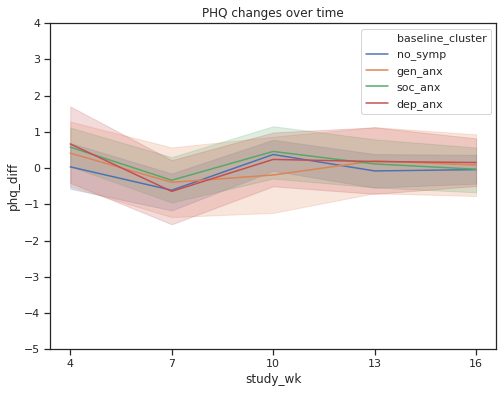

In [8]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=phq_corr, ax=ax)
plt.xticks([4, 7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("PHQ changes over time")
plt.show()

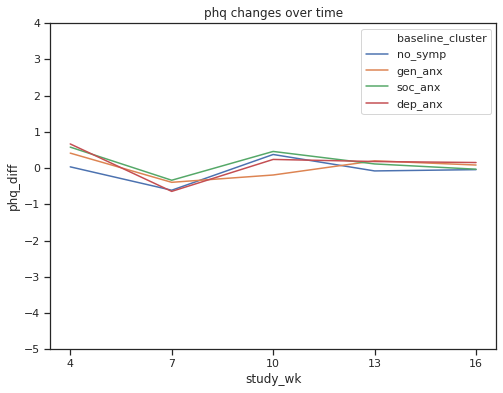

In [9]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=phq_corr, ax=ax,
                 ci=None)
plt.xticks([4,7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("phq changes over time")
plt.show()

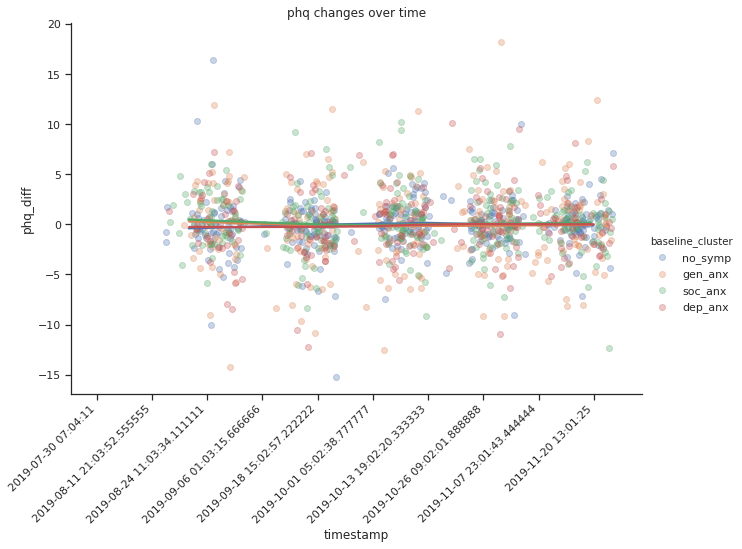

In [10]:
import matplotlib.dates as md

phq_corr['timestamp'] = (phq_corr['phq_start'] - dt.datetime(1970,1,1)).dt.total_seconds()


sns.lmplot(x='timestamp', y='phq_diff', 
           data=phq_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(phq_corr['timestamp'].min(), phq_corr['timestamp'].max(), 10)
idx = pd.date_range(phq_corr['phq_start'].min(), phq_corr['phq_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("phq changes over time")
plt.show()

In [11]:
train_cluster = pd.read_pickle("ls_data/train_cluster.df").to_frame()
test_cluster = pd.read_pickle("ls_data/test_cluster.df").to_frame()
cluster_df = train_cluster.append(test_cluster)
cluster_df = cluster_df.reset_index()

cluster_df['cluster'] = cluster_df['cluster'].map({
    0: 'no_symp',
    1: 'soc_anx',
    2: 'gen_anx',
    3: 'dep_anx'
})

cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

Text(0.5, 1.0, 'Within individual PHQ shift variance')

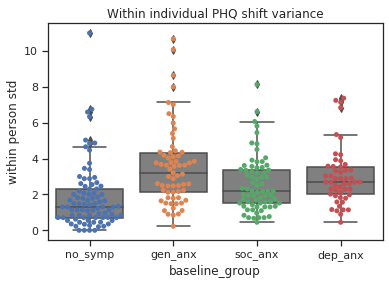

In [12]:

phq_std = phq_corr.groupby('pid')['phq_diff'].std()
phq_std = phq_std.to_frame().reset_index()
phq_std['baseline_group'] = phq_std['pid'].map(cluster_dict)
phq_std = phq_std.rename(columns={'phq_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=phq_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=phq_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual PHQ shift variance")

In [13]:
phq_std.groupby('baseline_group').describe()

within person std                                          \
                           count      mean       std       min       25%   
baseline_group                                                             
dep_anx                     51.0  2.993774  1.597988  0.447214  1.999905   
gen_anx                     65.0  3.547788  2.176730  0.223607  2.121320   
no_symp                     86.0  1.847536  1.798082  0.000000  0.707107   
soc_anx                     70.0  2.583030  1.537872  0.447214  1.516575   

                                               
                     50%       75%        max  
baseline_group                                 
dep_anx         2.687419  3.549620   7.368853  
gen_anx         3.213254  4.335897  10.677078  
no_symp         1.322741  2.306240  11.000000  
soc_anx         2.190890  3.386217   8.136338

### SPIN

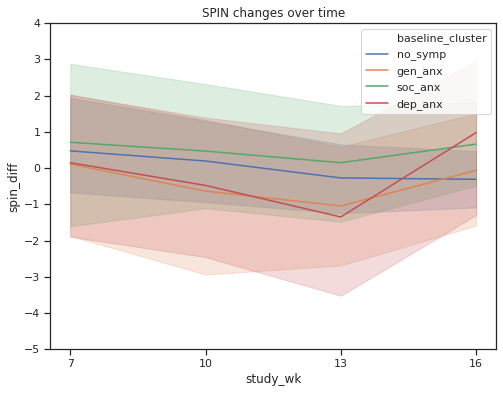

In [14]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

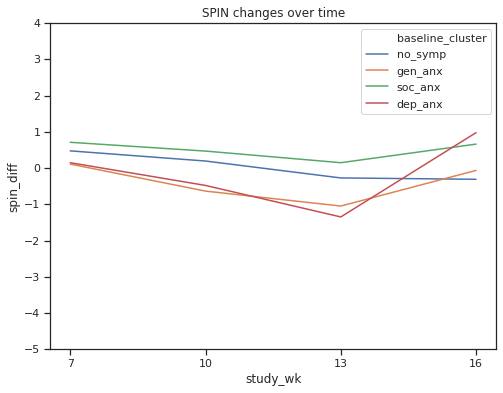

In [15]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

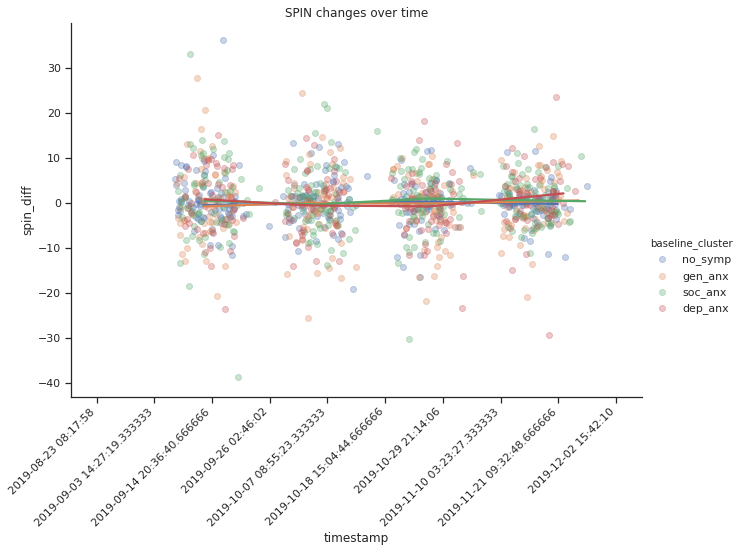

In [16]:
import matplotlib.dates as md

gad_spin_corr['timestamp'] = (gad_spin_corr['spin_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

sns.lmplot(x='timestamp', y='spin_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("SPIN changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual SPIN shift variance')

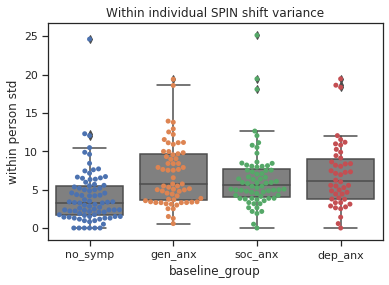

In [17]:

spin_std = gad_spin_corr.groupby('pid')['spin_diff'].std()
spin_std = spin_std.to_frame().reset_index()
spin_std['baseline_group'] = spin_std['pid'].map(cluster_dict)
spin_std = spin_std.rename(columns={'spin_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=spin_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=spin_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual SPIN shift variance")

In [18]:
spin_std.groupby('baseline_group').describe()

within person std                                         \
                           count      mean       std      min       25%   
baseline_group                                                            
dep_anx                     46.0  6.969471  4.364506  0.00000  3.810133   
gen_anx                     63.0  6.981505  4.027708  0.57735  3.622292   
no_symp                     82.0  4.024435  3.620225  0.00000  1.657758   
soc_anx                     68.0  6.435462  4.077029  0.00000  4.052987   

                                               
                     50%       75%        max  
baseline_group                                 
dep_anx         6.129560  9.000743  19.433648  
gen_anx         5.737305  9.617501  19.379972  
no_symp         3.265986  5.469209  24.608603  
soc_anx         5.624505  7.642549  25.118055

### GAD

In [19]:
gad_spin_corr['gad_diff'] = gad_spin_corr['gad_diff'].astype(float)

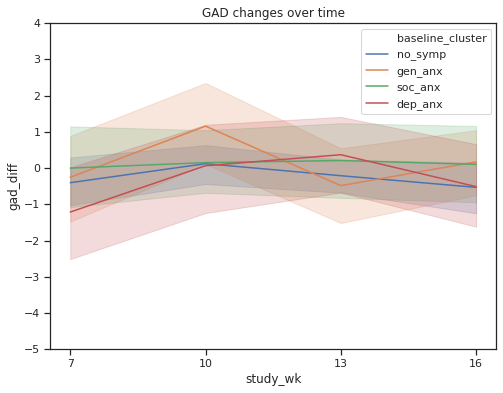

In [20]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

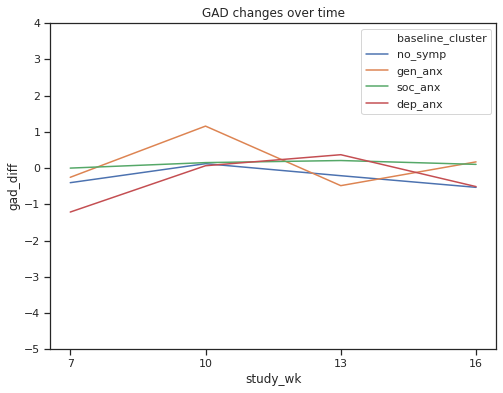

In [21]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

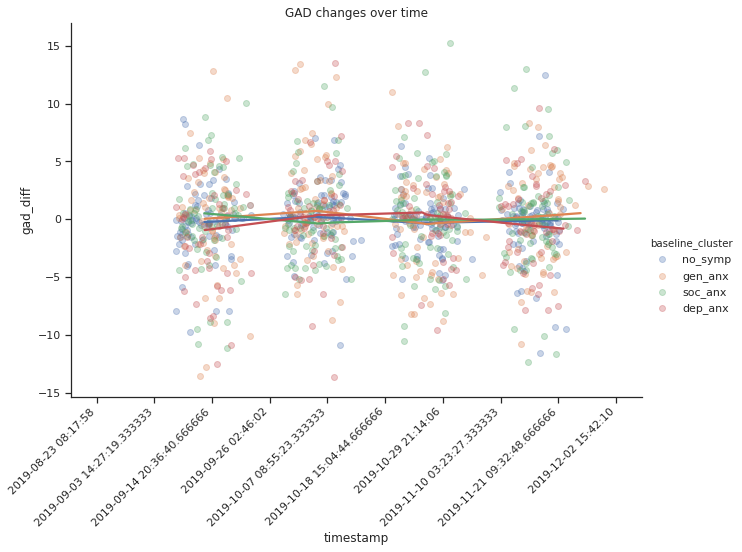

In [22]:
import matplotlib.dates as md

gad_spin_corr['timestamp'] = (gad_spin_corr['gad_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

sns.lmplot(x='timestamp', y='gad_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("GAD changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual gad shift variance')

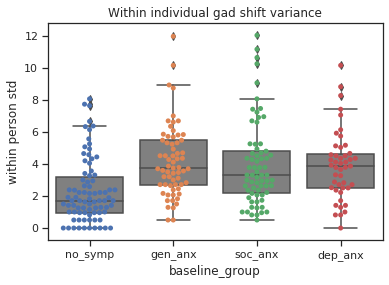

In [23]:

gad_std = gad_spin_corr.groupby('pid')['gad_diff'].std()
gad_std = gad_std.to_frame().reset_index()
gad_std['baseline_group'] = gad_std['pid'].map(cluster_dict)
gad_std = gad_std.rename(columns={'gad_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=gad_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=gad_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual gad shift variance")

In [24]:
gad_std.groupby('baseline_group').describe()

within person std                                               \
                           count      mean       std  min       25%       50%   
baseline_group                                                                  
dep_anx                     46.0  3.907512  2.145929  0.0  2.504153  3.888995   
gen_anx                     64.0  4.192597  2.211141  0.5  2.708013  3.758287   
no_symp                     82.0  2.328305  1.999417  0.0  0.968070  1.707825   
soc_anx                     68.0  3.990012  2.632820  0.5  2.203079  3.304038   

                                     
                     75%        max  
baseline_group                       
dep_anx         4.634429  10.144785  
gen_anx         5.477226  11.954776  
no_symp         3.199490   8.057088  
soc_anx         4.830094  12.020815

# SPIN

## Full population

In [25]:
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1028,0.018,0.5654,0.7732,fdr_bh
1,passive_apps_agg_change,spin_diff,1028,0.043,0.1665,0.4995,fdr_bh
2,social_apps_agg_change,spin_diff,1028,-0.004,0.9010,0.9654,fdr_bh
3,work_dur_agg_change,spin_diff,1023,-0.001,0.9785,0.9785,fdr_bh
4,home_dur_agg_change,spin_diff,1023,0.018,0.5670,0.7732,fdr_bh
5,religion_dur_agg_change,spin_diff,1023,0.025,0.4195,0.6992,fdr_bh
6,exercise_dur_agg_change,spin_diff,1023,-0.013,0.6820,0.8525,fdr_bh
7,shopping_dur_agg_change,spin_diff,1023,-0.033,0.2910,0.5740,fdr_bh
8,other_dur_agg_change,spin_diff,1023,0.032,0.3061,0.5740,fdr_bh
9,social_dur_agg_change,spin_diff,1023,-0.076,0.0145*,0.2169,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1028,0.009,0.7828,0.8081,fdr_bh
1,passive_apps_agg_change,spin_diff,1028,0.078,0.0120*,0.0894*,fdr_bh
2,social_apps_agg_change,spin_diff,1028,0.017,0.5801,0.7251,fdr_bh
3,work_dur_agg_change,spin_diff,1023,-0.021,0.4999,0.7251,fdr_bh
4,home_dur_agg_change,spin_diff,1023,0.01,0.7433,0.8081,fdr_bh
5,religion_dur_agg_change,spin_diff,1023,0.008,0.8081,0.8081,fdr_bh
6,exercise_dur_agg_change,spin_diff,1023,0.033,0.2859,0.6530,fdr_bh
7,shopping_dur_agg_change,spin_diff,1023,0.029,0.3557,0.6670,fdr_bh
8,other_dur_agg_change,spin_diff,1023,0.018,0.5700,0.7251,fdr_bh
9,social_dur_agg_change,spin_diff,1023,-0.052,0.0965*,0.3620,fdr_bh


## no_symp

In [26]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,325,0.035,0.5260,0.8136,fdr_bh
1,passive_apps_agg_change,spin_diff,325,0.04,0.4707,0.8136,fdr_bh
2,social_apps_agg_change,spin_diff,325,0.007,0.8998,0.9641,fdr_bh
3,work_dur_agg_change,spin_diff,325,-0.05,0.3725,0.8136,fdr_bh
4,home_dur_agg_change,spin_diff,325,0.002,0.9655,0.9655,fdr_bh
5,religion_dur_agg_change,spin_diff,325,0.012,0.8249,0.9641,fdr_bh
6,exercise_dur_agg_change,spin_diff,325,0.011,0.8460,0.9641,fdr_bh
7,shopping_dur_agg_change,spin_diff,325,-0.084,0.1311,0.8136,fdr_bh
8,other_dur_agg_change,spin_diff,325,0.071,0.1986,0.8136,fdr_bh
9,social_dur_agg_change,spin_diff,325,-0.066,0.2373,0.8136,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,325,0.069,0.2135,0.5415,fdr_bh
1,passive_apps_agg_change,spin_diff,325,0.084,0.1309,0.5415,fdr_bh
2,social_apps_agg_change,spin_diff,325,0.064,0.2527,0.5415,fdr_bh
3,work_dur_agg_change,spin_diff,325,-0.065,0.2418,0.5415,fdr_bh
4,home_dur_agg_change,spin_diff,325,0.051,0.3594,0.5724,fdr_bh
5,religion_dur_agg_change,spin_diff,325,-0.065,0.2425,0.5415,fdr_bh
6,exercise_dur_agg_change,spin_diff,325,0.047,0.3940,0.5724,fdr_bh
7,shopping_dur_agg_change,spin_diff,325,0.014,0.8047,0.8047,fdr_bh
8,other_dur_agg_change,spin_diff,325,0.041,0.4579,0.5724,fdr_bh
9,social_dur_agg_change,spin_diff,325,-0.083,0.1338,0.5415,fdr_bh


## soc_anx

In [27]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,267,0.056,0.3599,0.7711,fdr_bh
1,passive_apps_agg_change,spin_diff,267,0.039,0.5299,0.7749,fdr_bh
2,social_apps_agg_change,spin_diff,267,0.028,0.6524,0.7749,fdr_bh
3,work_dur_agg_change,spin_diff,267,0.032,0.6020,0.7749,fdr_bh
4,home_dur_agg_change,spin_diff,267,0.058,0.3452,0.7711,fdr_bh
5,religion_dur_agg_change,spin_diff,267,0.13,0.0341*,0.2557,fdr_bh
6,exercise_dur_agg_change,spin_diff,267,-0.064,0.2970,0.7711,fdr_bh
7,shopping_dur_agg_change,spin_diff,267,-0.111,0.0712*,0.2669,fdr_bh
8,other_dur_agg_change,spin_diff,267,0.014,0.8232,0.8820,fdr_bh
9,social_dur_agg_change,spin_diff,267,-0.116,0.0582*,0.2669,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,267,0.03,0.6205,0.7700,fdr_bh
1,passive_apps_agg_change,spin_diff,267,0.143,0.0191*,0.2860,fdr_bh
2,social_apps_agg_change,spin_diff,267,0.06,0.3309,0.6204,fdr_bh
3,work_dur_agg_change,spin_diff,267,0.012,0.8391,0.8391,fdr_bh
4,home_dur_agg_change,spin_diff,267,0.078,0.2061,0.4790,fdr_bh
5,religion_dur_agg_change,spin_diff,267,0.076,0.2181,0.4790,fdr_bh
6,exercise_dur_agg_change,spin_diff,267,0.078,0.2012,0.4790,fdr_bh
7,shopping_dur_agg_change,spin_diff,267,0.035,0.5678,0.7700,fdr_bh
8,other_dur_agg_change,spin_diff,267,0.075,0.2235,0.4790,fdr_bh
9,social_dur_agg_change,spin_diff,267,-0.095,0.1223,0.4790,fdr_bh


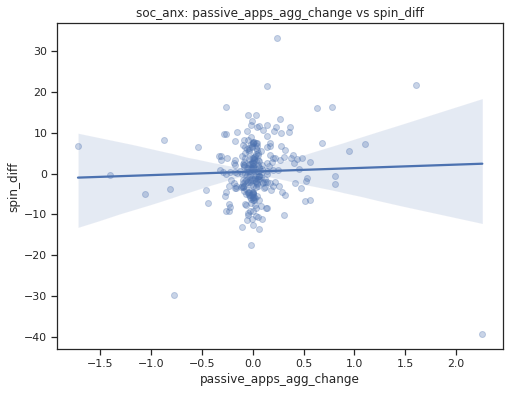

In [28]:
ls_utils.plot_cluster_scatter('passive_apps_agg_change', 'spin_diff', sel_state_df, 'soc_anx', (8,6))

## gen_anx

In [29]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,252,-0.069,0.2773,0.6624,fdr_bh
1,passive_apps_agg_change,spin_diff,252,0.006,0.9233,0.9233,fdr_bh
2,social_apps_agg_change,spin_diff,252,-0.048,0.4484,0.6726,fdr_bh
3,work_dur_agg_change,spin_diff,251,-0.023,0.7154,0.7665,fdr_bh
4,home_dur_agg_change,spin_diff,251,-0.055,0.3861,0.6726,fdr_bh
5,religion_dur_agg_change,spin_diff,251,0.03,0.6411,0.7397,fdr_bh
6,exercise_dur_agg_change,spin_diff,251,0.049,0.4395,0.6726,fdr_bh
7,shopping_dur_agg_change,spin_diff,251,0.103,0.1039,0.3895,fdr_bh
8,other_dur_agg_change,spin_diff,251,0.04,0.5235,0.6973,fdr_bh
9,social_dur_agg_change,spin_diff,251,-0.071,0.2640,0.6624,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,252,-0.068,0.2829,0.5041,fdr_bh
1,passive_apps_agg_change,spin_diff,252,0.054,0.3977,0.5637,fdr_bh
2,social_apps_agg_change,spin_diff,252,-0.04,0.5318,0.6340,fdr_bh
3,work_dur_agg_change,spin_diff,251,-0.065,0.3025,0.5041,fdr_bh
4,home_dur_agg_change,spin_diff,251,-0.074,0.2455,0.5041,fdr_bh
5,religion_dur_agg_change,spin_diff,251,0.079,0.2108,0.5041,fdr_bh
6,exercise_dur_agg_change,spin_diff,251,0.038,0.5495,0.6340,fdr_bh
7,shopping_dur_agg_change,spin_diff,251,0.09,0.1529,0.4587,fdr_bh
8,other_dur_agg_change,spin_diff,251,-0.052,0.4134,0.5637,fdr_bh
9,social_dur_agg_change,spin_diff,251,-0.031,0.6235,0.6681,fdr_bh


## dep_anx

In [30]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,184,0.044,0.5526,0.9827,fdr_bh
1,passive_apps_agg_change,spin_diff,184,0.138,0.0622*,0.8127,fdr_bh
2,social_apps_agg_change,spin_diff,184,-0.002,0.9778,0.9827,fdr_bh
3,work_dur_agg_change,spin_diff,180,-0.004,0.9561,0.9827,fdr_bh
4,home_dur_agg_change,spin_diff,180,0.074,0.3251,0.8127,fdr_bh
5,religion_dur_agg_change,spin_diff,180,-0.083,0.2674,0.8127,fdr_bh
6,exercise_dur_agg_change,spin_diff,180,-0.081,0.2803,0.8127,fdr_bh
7,shopping_dur_agg_change,spin_diff,180,-0.002,0.9827,0.9827,fdr_bh
8,other_dur_agg_change,spin_diff,180,-0.01,0.8930,0.9827,fdr_bh
9,social_dur_agg_change,spin_diff,180,-0.045,0.5527,0.9827,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,184,-0.018,0.8034,0.9562,fdr_bh
1,passive_apps_agg_change,spin_diff,184,0.032,0.6669,0.9562,fdr_bh
2,social_apps_agg_change,spin_diff,184,-0.019,0.7994,0.9562,fdr_bh
3,work_dur_agg_change,spin_diff,180,0.045,0.5442,0.9562,fdr_bh
4,home_dur_agg_change,spin_diff,180,-0.008,0.9132,0.9562,fdr_bh
5,religion_dur_agg_change,spin_diff,180,-0.071,0.3427,0.9562,fdr_bh
6,exercise_dur_agg_change,spin_diff,180,-0.095,0.2069,0.9562,fdr_bh
7,shopping_dur_agg_change,spin_diff,180,-0.046,0.5435,0.9562,fdr_bh
8,other_dur_agg_change,spin_diff,180,-0.011,0.8822,0.9562,fdr_bh
9,social_dur_agg_change,spin_diff,180,0.009,0.9014,0.9562,fdr_bh


# Reverse SPIN

## Full population

In [31]:
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1023,0.037,0.2344,0.5989,fdr_bh
1,passive_apps_agg_change,spin_diff,1023,-0.008,0.7957,0.9149,fdr_bh
2,social_apps_agg_change,spin_diff,1023,0.025,0.4259,0.7985,fdr_bh
3,work_dur_agg_change,spin_diff,1020,0.009,0.7707,0.9149,fdr_bh
4,home_dur_agg_change,spin_diff,1020,0.033,0.2948,0.6317,fdr_bh
5,religion_dur_agg_change,spin_diff,1020,0.052,0.0973*,0.4867,fdr_bh
6,exercise_dur_agg_change,spin_diff,1020,-0.059,0.0581*,0.4867,fdr_bh
7,shopping_dur_agg_change,spin_diff,1020,0.013,0.6899,0.9149,fdr_bh
8,other_dur_agg_change,spin_diff,1020,0.003,0.9149,0.9149,fdr_bh
9,social_dur_agg_change,spin_diff,1020,0.046,0.1451,0.5440,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1023,0.024,0.4347,0.7524,fdr_bh
1,passive_apps_agg_change,spin_diff,1023,0.007,0.8229,0.9211,fdr_bh
2,social_apps_agg_change,spin_diff,1023,0.046,0.1448,0.7238,fdr_bh
3,work_dur_agg_change,spin_diff,1020,0.029,0.3498,0.7524,fdr_bh
4,home_dur_agg_change,spin_diff,1020,0.033,0.2939,0.7524,fdr_bh
5,religion_dur_agg_change,spin_diff,1020,0.019,0.5438,0.7793,fdr_bh
6,exercise_dur_agg_change,spin_diff,1020,-0.018,0.5715,0.7793,fdr_bh
7,shopping_dur_agg_change,spin_diff,1020,-0.004,0.9002,0.9211,fdr_bh
8,other_dur_agg_change,spin_diff,1020,0.059,0.0585*,0.4384,fdr_bh
9,social_dur_agg_change,spin_diff,1020,0.036,0.2469,0.7524,fdr_bh


## no_symp

In [32]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,325,0.006,0.9166,0.9606,fdr_bh
1,passive_apps_agg_change,spin_diff,325,0.028,0.6168,0.7699,fdr_bh
2,social_apps_agg_change,spin_diff,325,0.026,0.6418,0.7699,fdr_bh
3,work_dur_agg_change,spin_diff,325,0.058,0.2934,0.6621,fdr_bh
4,home_dur_agg_change,spin_diff,325,0.003,0.9606,0.9606,fdr_bh
5,religion_dur_agg_change,spin_diff,325,0.052,0.3531,0.6621,fdr_bh
6,exercise_dur_agg_change,spin_diff,325,-0.071,0.2027,0.6621,fdr_bh
7,shopping_dur_agg_change,spin_diff,325,0.13,0.0191*,0.2865,fdr_bh
8,other_dur_agg_change,spin_diff,325,0.024,0.6672,0.7699,fdr_bh
9,social_dur_agg_change,spin_diff,325,0.088,0.1114,0.6621,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,325,-0.014,0.8021,0.8899,fdr_bh
1,passive_apps_agg_change,spin_diff,325,0.016,0.7734,0.8899,fdr_bh
2,social_apps_agg_change,spin_diff,325,0.09,0.1059,0.7276,fdr_bh
3,work_dur_agg_change,spin_diff,325,0.027,0.6319,0.8617,fdr_bh
4,home_dur_agg_change,spin_diff,325,0.012,0.8306,0.8899,fdr_bh
5,religion_dur_agg_change,spin_diff,325,0.057,0.3030,0.7576,fdr_bh
6,exercise_dur_agg_change,spin_diff,325,-0.003,0.9583,0.9583,fdr_bh
7,shopping_dur_agg_change,spin_diff,325,0.034,0.5380,0.8617,fdr_bh
8,other_dur_agg_change,spin_diff,325,0.028,0.6127,0.8617,fdr_bh
9,social_dur_agg_change,spin_diff,325,0.09,0.1054,0.7276,fdr_bh


## soc_anx

In [33]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,266,0.047,0.4405,0.7877,fdr_bh
1,passive_apps_agg_change,spin_diff,266,-0.126,0.0398*,0.2982,fdr_bh
2,social_apps_agg_change,spin_diff,266,-0.035,0.5659,0.7877,fdr_bh
3,work_dur_agg_change,spin_diff,266,-0.077,0.2133,0.6399,fdr_bh
4,home_dur_agg_change,spin_diff,266,0.016,0.7905,0.8470,fdr_bh
5,religion_dur_agg_change,spin_diff,266,0.155,0.0114*,0.1704,fdr_bh
6,exercise_dur_agg_change,spin_diff,266,-0.087,0.1557,0.5838,fdr_bh
7,shopping_dur_agg_change,spin_diff,266,0.008,0.9012,0.9012,fdr_bh
8,other_dur_agg_change,spin_diff,266,0.037,0.5472,0.7877,fdr_bh
9,social_dur_agg_change,spin_diff,266,0.048,0.4380,0.7877,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,266,0.044,0.4706,0.7850,fdr_bh
1,passive_apps_agg_change,spin_diff,266,-0.046,0.4513,0.7850,fdr_bh
2,social_apps_agg_change,spin_diff,266,-0.015,0.8111,0.9829,fdr_bh
3,work_dur_agg_change,spin_diff,266,-0.044,0.4710,0.7850,fdr_bh
4,home_dur_agg_change,spin_diff,266,-0.004,0.9530,0.9829,fdr_bh
5,religion_dur_agg_change,spin_diff,266,0.06,0.3311,0.7850,fdr_bh
6,exercise_dur_agg_change,spin_diff,266,0.001,0.9829,0.9829,fdr_bh
7,shopping_dur_agg_change,spin_diff,266,0.009,0.8861,0.9829,fdr_bh
8,other_dur_agg_change,spin_diff,266,0.181,0.0031*,0.0465*,fdr_bh
9,social_dur_agg_change,spin_diff,266,0.024,0.7018,0.9570,fdr_bh


## gen_anx

In [34]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,251,0.084,0.1853,0.6546,fdr_bh
1,passive_apps_agg_change,spin_diff,251,0.037,0.5631,0.6546,fdr_bh
2,social_apps_agg_change,spin_diff,251,0.043,0.4982,0.6546,fdr_bh
3,work_dur_agg_change,spin_diff,251,0.03,0.6417,0.6546,fdr_bh
4,home_dur_agg_change,spin_diff,251,0.094,0.1368,0.6546,fdr_bh
5,religion_dur_agg_change,spin_diff,251,-0.03,0.6416,0.6546,fdr_bh
6,exercise_dur_agg_change,spin_diff,251,-0.073,0.2477,0.6546,fdr_bh
7,shopping_dur_agg_change,spin_diff,251,-0.028,0.6546,0.6546,fdr_bh
8,other_dur_agg_change,spin_diff,251,-0.036,0.5709,0.6546,fdr_bh
9,social_dur_agg_change,spin_diff,251,-0.03,0.6361,0.6546,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,251,0.072,0.2538,0.6985,fdr_bh
1,passive_apps_agg_change,spin_diff,251,0.022,0.7309,0.7864,fdr_bh
2,social_apps_agg_change,spin_diff,251,0.049,0.4415,0.6985,fdr_bh
3,work_dur_agg_change,spin_diff,251,0.046,0.4698,0.6985,fdr_bh
4,home_dur_agg_change,spin_diff,251,0.086,0.1755,0.6985,fdr_bh
5,religion_dur_agg_change,spin_diff,251,-0.058,0.3634,0.6985,fdr_bh
6,exercise_dur_agg_change,spin_diff,251,-0.093,0.1400,0.6985,fdr_bh
7,shopping_dur_agg_change,spin_diff,251,-0.017,0.7864,0.7864,fdr_bh
8,other_dur_agg_change,spin_diff,251,-0.045,0.4793,0.6985,fdr_bh
9,social_dur_agg_change,spin_diff,251,-0.077,0.2253,0.6985,fdr_bh


## dep_anx

In [35]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,181,-0.01,0.8926,0.9907,fdr_bh
1,passive_apps_agg_change,spin_diff,181,0.089,0.2324,0.9907,fdr_bh
2,social_apps_agg_change,spin_diff,181,0.056,0.4556,0.9907,fdr_bh
3,work_dur_agg_change,spin_diff,178,0.078,0.3001,0.9907,fdr_bh
4,home_dur_agg_change,spin_diff,178,0.006,0.9374,0.9907,fdr_bh
5,religion_dur_agg_change,spin_diff,178,0.035,0.6381,0.9907,fdr_bh
6,exercise_dur_agg_change,spin_diff,178,0.024,0.7483,0.9907,fdr_bh
7,shopping_dur_agg_change,spin_diff,178,-0.092,0.2198,0.9907,fdr_bh
8,other_dur_agg_change,spin_diff,178,0.019,0.8062,0.9907,fdr_bh
9,social_dur_agg_change,spin_diff,178,0.076,0.3116,0.9907,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,181,-0.021,0.7825,0.9670,fdr_bh
1,passive_apps_agg_change,spin_diff,181,0.069,0.3542,0.8854,fdr_bh
2,social_apps_agg_change,spin_diff,181,0.073,0.3317,0.8854,fdr_bh
3,work_dur_agg_change,spin_diff,178,0.1,0.1822,0.8854,fdr_bh
4,home_dur_agg_change,spin_diff,178,0.053,0.4850,0.9670,fdr_bh
5,religion_dur_agg_change,spin_diff,178,-0.007,0.9280,0.9721,fdr_bh
6,exercise_dur_agg_change,spin_diff,178,0.033,0.6606,0.9670,fdr_bh
7,shopping_dur_agg_change,spin_diff,178,-0.043,0.5688,0.9670,fdr_bh
8,other_dur_agg_change,spin_diff,178,0.076,0.3119,0.8854,fdr_bh
9,social_dur_agg_change,spin_diff,178,0.117,0.1186,0.8854,fdr_bh


# GAD

## Full population

In [36]:
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1029,0.044,0.1581,0.4729,fdr_bh
1,passive_apps_agg_change,gad_diff,1029,0.026,0.4133,0.6199,fdr_bh
2,social_apps_agg_change,gad_diff,1029,-0.033,0.2838,0.4729,fdr_bh
3,work_dur_agg_change,gad_diff,1024,0.049,0.1143,0.4729,fdr_bh
4,home_dur_agg_change,gad_diff,1024,0.011,0.7366,0.7366,fdr_bh
5,religion_dur_agg_change,gad_diff,1024,0.013,0.6821,0.7308,fdr_bh
6,exercise_dur_agg_change,gad_diff,1024,0.014,0.6567,0.7308,fdr_bh
7,shopping_dur_agg_change,gad_diff,1024,-0.034,0.2795,0.4729,fdr_bh
8,other_dur_agg_change,gad_diff,1024,-0.044,0.1579,0.4729,fdr_bh
9,social_dur_agg_change,gad_diff,1024,-0.034,0.2710,0.4729,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1029,0.083,0.0079*,0.0720*,fdr_bh
1,passive_apps_agg_change,gad_diff,1029,0.023,0.4578,0.7097,fdr_bh
2,social_apps_agg_change,gad_diff,1029,-0.028,0.3621,0.7049,fdr_bh
3,work_dur_agg_change,gad_diff,1024,0.07,0.0249*,0.0935*,fdr_bh
4,home_dur_agg_change,gad_diff,1024,-0.002,0.9427,0.9427,fdr_bh
5,religion_dur_agg_change,gad_diff,1024,-0.004,0.8886,0.9427,fdr_bh
6,exercise_dur_agg_change,gad_diff,1024,0.017,0.5868,0.7900,fdr_bh
7,shopping_dur_agg_change,gad_diff,1024,-0.004,0.8955,0.9427,fdr_bh
8,other_dur_agg_change,gad_diff,1024,-0.015,0.6320,0.7900,fdr_bh
9,social_dur_agg_change,gad_diff,1024,-0.022,0.4731,0.7097,fdr_bh


## no_symp

In [37]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,325,-0.008,0.8900,0.8900,fdr_bh
1,passive_apps_agg_change,gad_diff,325,0.071,0.2018,0.6255,fdr_bh
2,social_apps_agg_change,gad_diff,325,0.095,0.0857*,0.4283,fdr_bh
3,work_dur_agg_change,gad_diff,325,0.02,0.7231,0.7747,fdr_bh
4,home_dur_agg_change,gad_diff,325,0.118,0.0330*,0.2498,fdr_bh
5,religion_dur_agg_change,gad_diff,325,-0.023,0.6795,0.7747,fdr_bh
6,exercise_dur_agg_change,gad_diff,325,0.046,0.4126,0.6343,fdr_bh
7,shopping_dur_agg_change,gad_diff,325,0.037,0.5074,0.6343,fdr_bh
8,other_dur_agg_change,gad_diff,325,-0.061,0.2736,0.6255,fdr_bh
9,social_dur_agg_change,gad_diff,325,-0.043,0.4345,0.6343,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,325,0.003,0.9567,0.9567,fdr_bh
1,passive_apps_agg_change,gad_diff,325,0.109,0.0495*,0.7021,fdr_bh
2,social_apps_agg_change,gad_diff,325,0.073,0.1917,0.7021,fdr_bh
3,work_dur_agg_change,gad_diff,325,-0.022,0.6927,0.7622,fdr_bh
4,home_dur_agg_change,gad_diff,325,0.027,0.6262,0.7622,fdr_bh
5,religion_dur_agg_change,gad_diff,325,-0.063,0.2572,0.7021,fdr_bh
6,exercise_dur_agg_change,gad_diff,325,0.04,0.4761,0.7622,fdr_bh
7,shopping_dur_agg_change,gad_diff,325,-0.025,0.6595,0.7622,fdr_bh
8,other_dur_agg_change,gad_diff,325,0.091,0.1033,0.7021,fdr_bh
9,social_dur_agg_change,gad_diff,325,0.035,0.5299,0.7622,fdr_bh


## soc_anx

In [38]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,267,0.084,0.1711,0.7728,fdr_bh
1,passive_apps_agg_change,gad_diff,267,0.062,0.3091,0.7728,fdr_bh
2,social_apps_agg_change,gad_diff,267,0.003,0.9574,0.9971,fdr_bh
3,work_dur_agg_change,gad_diff,267,-0,0.9971,0.9971,fdr_bh
4,home_dur_agg_change,gad_diff,267,0.029,0.6346,0.9519,fdr_bh
5,religion_dur_agg_change,gad_diff,267,0.068,0.2659,0.7728,fdr_bh
6,exercise_dur_agg_change,gad_diff,267,-0.047,0.4411,0.9169,fdr_bh
7,shopping_dur_agg_change,gad_diff,267,-0.077,0.2103,0.7728,fdr_bh
8,other_dur_agg_change,gad_diff,267,0.009,0.8791,0.9971,fdr_bh
9,social_dur_agg_change,gad_diff,267,-0.022,0.7225,0.9852,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,267,0.189,0.0019*,0.0275*,fdr_bh
1,passive_apps_agg_change,gad_diff,267,0.049,0.4299,0.7523,fdr_bh
2,social_apps_agg_change,gad_diff,267,0.038,0.5333,0.7523,fdr_bh
3,work_dur_agg_change,gad_diff,267,0.037,0.5517,0.7523,fdr_bh
4,home_dur_agg_change,gad_diff,267,0.045,0.4648,0.7523,fdr_bh
5,religion_dur_agg_change,gad_diff,267,0.083,0.1772,0.6472,fdr_bh
6,exercise_dur_agg_change,gad_diff,267,-0.01,0.8651,0.9242,fdr_bh
7,shopping_dur_agg_change,gad_diff,267,0.011,0.8621,0.9242,fdr_bh
8,other_dur_agg_change,gad_diff,267,-0.013,0.8276,0.9242,fdr_bh
9,social_dur_agg_change,gad_diff,267,-0.006,0.9242,0.9242,fdr_bh


## gen_anx

In [39]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,253,0.099,0.1167,0.6978,fdr_bh
1,passive_apps_agg_change,gad_diff,253,-0.054,0.3923,0.6978,fdr_bh
2,social_apps_agg_change,gad_diff,253,-0,0.9977,0.9977,fdr_bh
3,work_dur_agg_change,gad_diff,252,0.068,0.2825,0.6978,fdr_bh
4,home_dur_agg_change,gad_diff,252,-0.086,0.1742,0.6978,fdr_bh
5,religion_dur_agg_change,gad_diff,252,-0.007,0.9165,0.9820,fdr_bh
6,exercise_dur_agg_change,gad_diff,252,0.045,0.4727,0.6978,fdr_bh
7,shopping_dur_agg_change,gad_diff,252,-0.05,0.4256,0.6978,fdr_bh
8,other_dur_agg_change,gad_diff,252,-0.053,0.4016,0.6978,fdr_bh
9,social_dur_agg_change,gad_diff,252,0.042,0.5023,0.6978,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,253,0.138,0.0284*,0.4264,fdr_bh
1,passive_apps_agg_change,gad_diff,253,-0.043,0.4972,0.8503,fdr_bh
2,social_apps_agg_change,gad_diff,253,-0.01,0.8687,0.8687,fdr_bh
3,work_dur_agg_change,gad_diff,252,0.114,0.0715*,0.5364,fdr_bh
4,home_dur_agg_change,gad_diff,252,-0.062,0.3238,0.8096,fdr_bh
5,religion_dur_agg_change,gad_diff,252,-0.08,0.2060,0.6620,fdr_bh
6,exercise_dur_agg_change,gad_diff,252,0.029,0.6458,0.8503,fdr_bh
7,shopping_dur_agg_change,gad_diff,252,-0.022,0.7263,0.8503,fdr_bh
8,other_dur_agg_change,gad_diff,252,-0.021,0.7369,0.8503,fdr_bh
9,social_dur_agg_change,gad_diff,252,-0.031,0.6255,0.8503,fdr_bh


## dep_anx

In [40]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,184,-0.053,0.4771,0.8541,fdr_bh
1,passive_apps_agg_change,gad_diff,184,0.006,0.9392,0.9392,fdr_bh
2,social_apps_agg_change,gad_diff,184,-0.22,0.0027*,0.0411*,fdr_bh
3,work_dur_agg_change,gad_diff,180,0.176,0.0182*,0.1368,fdr_bh
4,home_dur_agg_change,gad_diff,180,-0.017,0.8255,0.8845,fdr_bh
5,religion_dur_agg_change,gad_diff,180,0.043,0.5690,0.8541,fdr_bh
6,exercise_dur_agg_change,gad_diff,180,0.025,0.7402,0.8541,fdr_bh
7,shopping_dur_agg_change,gad_diff,180,0.028,0.7050,0.8541,fdr_bh
8,other_dur_agg_change,gad_diff,180,-0.109,0.1461,0.3652,fdr_bh
9,social_dur_agg_change,gad_diff,180,-0.147,0.0489*,0.1835,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,184,-0.014,0.8452,0.8527,fdr_bh
1,passive_apps_agg_change,gad_diff,184,-0.039,0.6014,0.7677,fdr_bh
2,social_apps_agg_change,gad_diff,184,-0.246,0.0008*,0.0115*,fdr_bh
3,work_dur_agg_change,gad_diff,180,0.159,0.0333*,0.1622,fdr_bh
4,home_dur_agg_change,gad_diff,180,-0.04,0.5963,0.7677,fdr_bh
5,religion_dur_agg_change,gad_diff,180,0.05,0.5055,0.7677,fdr_bh
6,exercise_dur_agg_change,gad_diff,180,-0.014,0.8527,0.8527,fdr_bh
7,shopping_dur_agg_change,gad_diff,180,0.038,0.6142,0.7677,fdr_bh
8,other_dur_agg_change,gad_diff,180,-0.139,0.0633*,0.1622,fdr_bh
9,social_dur_agg_change,gad_diff,180,-0.138,0.0649*,0.1622,fdr_bh


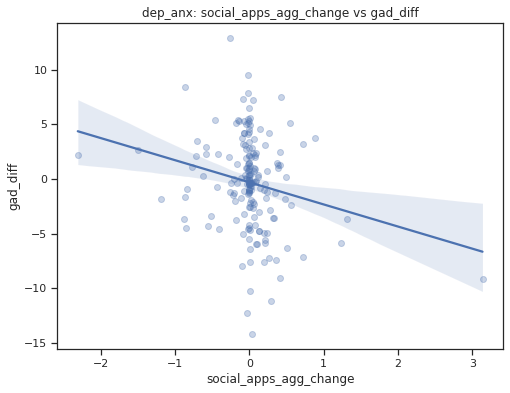

In [41]:
ls_utils.plot_cluster_scatter('social_apps_agg_change', 'gad_diff', gad_spin_corr, 'dep_anx', (8,6))

# Reverse GAD

## Full population

In [43]:
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1023,0.023,0.4716,0.7157,fdr_bh
1,passive_apps_agg_change,gad_diff,1023,-0.003,0.9296,0.9296,fdr_bh
2,social_apps_agg_change,gad_diff,1023,0.07,0.0242*,0.1817,fdr_bh
3,work_dur_agg_change,gad_diff,1020,-0.008,0.7863,0.8425,fdr_bh
4,home_dur_agg_change,gad_diff,1020,-0.038,0.2271,0.5843,fdr_bh
5,religion_dur_agg_change,gad_diff,1020,0.01,0.7449,0.8425,fdr_bh
6,exercise_dur_agg_change,gad_diff,1020,-0.034,0.2727,0.5843,fdr_bh
7,shopping_dur_agg_change,gad_diff,1020,-0.022,0.4771,0.7157,fdr_bh
8,other_dur_agg_change,gad_diff,1020,0.035,0.2583,0.5843,fdr_bh
9,social_dur_agg_change,gad_diff,1020,0.043,0.1665,0.5843,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1023,0.022,0.4827,0.6582,fdr_bh
1,passive_apps_agg_change,gad_diff,1023,-0.029,0.3555,0.5820,fdr_bh
2,social_apps_agg_change,gad_diff,1023,0.059,0.0590*,0.3641,fdr_bh
3,work_dur_agg_change,gad_diff,1020,-0.027,0.3880,0.5820,fdr_bh
4,home_dur_agg_change,gad_diff,1020,-0.041,0.1902,0.4756,fdr_bh
5,religion_dur_agg_change,gad_diff,1020,-0.043,0.1733,0.4756,fdr_bh
6,exercise_dur_agg_change,gad_diff,1020,-0.019,0.5493,0.6866,fdr_bh
7,shopping_dur_agg_change,gad_diff,1020,0.001,0.9671,0.9671,fdr_bh
8,other_dur_agg_change,gad_diff,1020,0.036,0.2468,0.5289,fdr_bh
9,social_dur_agg_change,gad_diff,1020,0.056,0.0728*,0.3641,fdr_bh


## no_symp

In [44]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,325,0.07,0.2066,0.4428,fdr_bh
1,passive_apps_agg_change,gad_diff,325,0.004,0.9434,0.9434,fdr_bh
2,social_apps_agg_change,gad_diff,325,-0.012,0.8289,0.9434,fdr_bh
3,work_dur_agg_change,gad_diff,325,0.007,0.8997,0.9434,fdr_bh
4,home_dur_agg_change,gad_diff,325,-0.037,0.5036,0.6867,fdr_bh
5,religion_dur_agg_change,gad_diff,325,-0.053,0.3449,0.5748,fdr_bh
6,exercise_dur_agg_change,gad_diff,325,0.026,0.6411,0.8014,fdr_bh
7,shopping_dur_agg_change,gad_diff,325,-0.101,0.0677*,0.2540,fdr_bh
8,other_dur_agg_change,gad_diff,325,0.127,0.0219*,0.1155,fdr_bh
9,social_dur_agg_change,gad_diff,325,0.075,0.1755,0.4388,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,325,0.07,0.2061,0.4903,fdr_bh
1,passive_apps_agg_change,gad_diff,325,-0.075,0.1763,0.4903,fdr_bh
2,social_apps_agg_change,gad_diff,325,-0.03,0.5863,0.7329,fdr_bh
3,work_dur_agg_change,gad_diff,325,-0.015,0.7876,0.8438,fdr_bh
4,home_dur_agg_change,gad_diff,325,-0.051,0.3558,0.5336,fdr_bh
5,religion_dur_agg_change,gad_diff,325,-0.04,0.4712,0.6425,fdr_bh
6,exercise_dur_agg_change,gad_diff,325,0.01,0.8625,0.8625,fdr_bh
7,shopping_dur_agg_change,gad_diff,325,-0.062,0.2634,0.4903,fdr_bh
8,other_dur_agg_change,gad_diff,325,0.067,0.2269,0.4903,fdr_bh
9,social_dur_agg_change,gad_diff,325,0.058,0.2942,0.4903,fdr_bh


## soc_anx

In [45]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,266,-0.045,0.4683,0.9081,fdr_bh
1,passive_apps_agg_change,gad_diff,266,0.021,0.7374,0.9128,fdr_bh
2,social_apps_agg_change,gad_diff,266,0.155,0.0114*,0.1708,fdr_bh
3,work_dur_agg_change,gad_diff,266,0.09,0.1427,0.5353,fdr_bh
4,home_dur_agg_change,gad_diff,266,0.007,0.9128,0.9128,fdr_bh
5,religion_dur_agg_change,gad_diff,266,0.097,0.1140,0.5353,fdr_bh
6,exercise_dur_agg_change,gad_diff,266,-0.072,0.2391,0.5978,fdr_bh
7,shopping_dur_agg_change,gad_diff,266,0.04,0.5195,0.9081,fdr_bh
8,other_dur_agg_change,gad_diff,266,0.007,0.9078,0.9128,fdr_bh
9,social_dur_agg_change,gad_diff,266,0.092,0.1344,0.5353,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,266,-0.054,0.3800,0.5371,fdr_bh
1,passive_apps_agg_change,gad_diff,266,-0.051,0.4111,0.5371,fdr_bh
2,social_apps_agg_change,gad_diff,266,0.174,0.0043*,0.0651*,fdr_bh
3,work_dur_agg_change,gad_diff,266,0.104,0.0905*,0.2651,fdr_bh
4,home_dur_agg_change,gad_diff,266,0.049,0.4257,0.5371,fdr_bh
5,religion_dur_agg_change,gad_diff,266,0.105,0.0876*,0.2651,fdr_bh
6,exercise_dur_agg_change,gad_diff,266,0.054,0.3840,0.5371,fdr_bh
7,shopping_dur_agg_change,gad_diff,266,0.149,0.0150*,0.1122,fdr_bh
8,other_dur_agg_change,gad_diff,266,0.095,0.1237,0.2651,fdr_bh
9,social_dur_agg_change,gad_diff,266,0.122,0.0466*,0.2332,fdr_bh


## gen_anx

In [46]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,251,0.049,0.4408,0.7347,fdr_bh
1,passive_apps_agg_change,gad_diff,251,-0.033,0.6026,0.7747,fdr_bh
2,social_apps_agg_change,gad_diff,251,0.078,0.2161,0.7347,fdr_bh
3,work_dur_agg_change,gad_diff,251,-0.08,0.2068,0.7347,fdr_bh
4,home_dur_agg_change,gad_diff,251,-0.058,0.3609,0.7347,fdr_bh
5,religion_dur_agg_change,gad_diff,251,-0.013,0.8355,0.8355,fdr_bh
6,exercise_dur_agg_change,gad_diff,251,-0.096,0.1303,0.7347,fdr_bh
7,shopping_dur_agg_change,gad_diff,251,-0.051,0.4225,0.7347,fdr_bh
8,other_dur_agg_change,gad_diff,251,-0.016,0.8042,0.8355,fdr_bh
9,social_dur_agg_change,gad_diff,251,0.065,0.3040,0.7347,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,251,0.032,0.6156,0.6595,fdr_bh
1,passive_apps_agg_change,gad_diff,251,0.042,0.5042,0.6595,fdr_bh
2,social_apps_agg_change,gad_diff,251,0.095,0.1321,0.5352,fdr_bh
3,work_dur_agg_change,gad_diff,251,-0.128,0.0429*,0.3221,fdr_bh
4,home_dur_agg_change,gad_diff,251,-0.052,0.4104,0.6595,fdr_bh
5,religion_dur_agg_change,gad_diff,251,-0.073,0.2497,0.5352,fdr_bh
6,exercise_dur_agg_change,gad_diff,251,-0.141,0.0260*,0.3221,fdr_bh
7,shopping_dur_agg_change,gad_diff,251,-0.052,0.4076,0.6595,fdr_bh
8,other_dur_agg_change,gad_diff,251,0.01,0.8768,0.8768,fdr_bh
9,social_dur_agg_change,gad_diff,251,0.042,0.5126,0.6595,fdr_bh


## dep_anx

In [47]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,181,0.066,0.3769,0.7573,fdr_bh
1,passive_apps_agg_change,gad_diff,181,-0.016,0.8297,0.9501,fdr_bh
2,social_apps_agg_change,gad_diff,181,0.074,0.3212,0.7573,fdr_bh
3,work_dur_agg_change,gad_diff,178,-0.092,0.2211,0.7573,fdr_bh
4,home_dur_agg_change,gad_diff,178,-0.079,0.2975,0.7573,fdr_bh
5,religion_dur_agg_change,gad_diff,178,-0.093,0.2177,0.7573,fdr_bh
6,exercise_dur_agg_change,gad_diff,178,0.012,0.8764,0.9501,fdr_bh
7,shopping_dur_agg_change,gad_diff,178,0.02,0.7864,0.9501,fdr_bh
8,other_dur_agg_change,gad_diff,178,0.035,0.6405,0.9501,fdr_bh
9,social_dur_agg_change,gad_diff,178,-0.063,0.4039,0.7573,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,181,0.044,0.5545,0.9273,fdr_bh
1,passive_apps_agg_change,gad_diff,181,-0.074,0.3237,0.8094,fdr_bh
2,social_apps_agg_change,gad_diff,181,-0.043,0.5634,0.9273,fdr_bh
3,work_dur_agg_change,gad_diff,178,-0.103,0.1729,0.6090,fdr_bh
4,home_dur_agg_change,gad_diff,178,-0.125,0.0971*,0.4854,fdr_bh
5,religion_dur_agg_change,gad_diff,178,-0.196,0.0087*,0.0650*,fdr_bh
6,exercise_dur_agg_change,gad_diff,178,-0.005,0.9500,0.9500,fdr_bh
7,shopping_dur_agg_change,gad_diff,178,-0.013,0.8606,0.9273,fdr_bh
8,other_dur_agg_change,gad_diff,178,-0.019,0.7988,0.9273,fdr_bh
9,social_dur_agg_change,gad_diff,178,-0.016,0.8343,0.9273,fdr_bh


# PHQ

## Entire population

In [48]:
phq_corr.columns

Index(['cluster', 'diff', 'mean_phq', 'phq01_sc', 'phq02_sc', 'phq03_sc',
       'phq04_sc', 'phq05_sc', 'phq06_sc', 'phq07_sc',
       ...
       'social_dur_agg_change', 'religion_dur_agg_change',
       'exercise_dur_agg_change', 'other_dur_agg_change', 'sms_agg_change',
       'cal_agg_change', 'movt_agg_change', 'wkday_total_entropy_agg_change',
       'wkend_entropy_agg_change', 'timestamp'],
      dtype='object', length=281)

In [49]:
ls_utils.display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.042,0.1670,0.2783,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,0.03,0.3253,0.4067,fdr_bh
2,social_apps_agg_change,phq_diff,1079,0.065,0.0321*,0.0801*,fdr_bh
3,work_dur_agg_change,phq_diff,1078,0.016,0.5889,0.6309,fdr_bh
4,home_dur_agg_change,phq_diff,1078,0.061,0.0470*,0.1006,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.039,0.1955,0.2932,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,0.111,0.0003*,0.0021*,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,-0.001,0.9750,0.9750,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.054,0.0765*,0.1434,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.068,0.0250*,0.0750*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.042,0.1638,0.2730,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,0.034,0.2613,0.3266,fdr_bh
2,social_apps_agg_change,phq_diff,1079,0.075,0.0141*,0.0527*,fdr_bh
3,work_dur_agg_change,phq_diff,1078,-0.016,0.5990,0.6418,fdr_bh
4,home_dur_agg_change,phq_diff,1078,0.071,0.0198*,0.0593*,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.039,0.1953,0.2929,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,0.078,0.0108*,0.0527*,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,-0.01,0.7448,0.7448,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.059,0.0509*,0.0954*,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.037,0.2259,0.3080,fdr_bh


## no_symp

In [50]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,326,-0.095,0.0878*,0.2898,fdr_bh
1,passive_apps_agg_change,phq_diff,326,0.012,0.8234,0.8901,fdr_bh
2,social_apps_agg_change,phq_diff,326,-0.018,0.7525,0.8901,fdr_bh
3,work_dur_agg_change,phq_diff,326,-0.092,0.0966*,0.2898,fdr_bh
4,home_dur_agg_change,phq_diff,326,-0.122,0.0278*,0.2084,fdr_bh
5,religion_dur_agg_change,phq_diff,326,-0.128,0.0211*,0.2084,fdr_bh
6,exercise_dur_agg_change,phq_diff,326,0.019,0.7306,0.8901,fdr_bh
7,shopping_dur_agg_change,phq_diff,326,-0.008,0.8818,0.8901,fdr_bh
8,other_dur_agg_change,phq_diff,326,0.02,0.7140,0.8901,fdr_bh
9,social_dur_agg_change,phq_diff,326,-0.016,0.7713,0.8901,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,326,-0.052,0.3495,0.8447,fdr_bh
1,passive_apps_agg_change,phq_diff,326,-0.032,0.5659,0.8489,fdr_bh
2,social_apps_agg_change,phq_diff,326,-0.011,0.8407,0.9886,fdr_bh
3,work_dur_agg_change,phq_diff,326,-0.104,0.0609*,0.5358,fdr_bh
4,home_dur_agg_change,phq_diff,326,-0.067,0.2274,0.7721,fdr_bh
5,religion_dur_agg_change,phq_diff,326,-0.089,0.1072,0.5358,fdr_bh
6,exercise_dur_agg_change,phq_diff,326,-0.042,0.4505,0.8447,fdr_bh
7,shopping_dur_agg_change,phq_diff,326,-0.034,0.5409,0.8489,fdr_bh
8,other_dur_agg_change,phq_diff,326,-0.09,0.1064,0.5358,fdr_bh
9,social_dur_agg_change,phq_diff,326,0.025,0.6594,0.8992,fdr_bh


## soc_anx

In [51]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,293,0.096,0.1004,0.2152,fdr_bh
1,passive_apps_agg_change,phq_diff,293,-0.059,0.3183,0.3979,fdr_bh
2,social_apps_agg_change,phq_diff,293,0.087,0.1396,0.2326,fdr_bh
3,work_dur_agg_change,phq_diff,293,0.088,0.1324,0.2326,fdr_bh
4,home_dur_agg_change,phq_diff,293,0.144,0.0134*,0.0504*,fdr_bh
5,religion_dur_agg_change,phq_diff,293,-0.021,0.7237,0.7237,fdr_bh
6,exercise_dur_agg_change,phq_diff,293,0.149,0.0104*,0.0504*,fdr_bh
7,shopping_dur_agg_change,phq_diff,293,-0.038,0.5225,0.5599,fdr_bh
8,other_dur_agg_change,phq_diff,293,-0.074,0.2054,0.2801,fdr_bh
9,social_dur_agg_change,phq_diff,293,-0.19,0.0011*,0.0163*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,293,0.072,0.2182,0.3409,fdr_bh
1,passive_apps_agg_change,phq_diff,293,0.049,0.3986,0.5435,fdr_bh
2,social_apps_agg_change,phq_diff,293,0.071,0.2273,0.3409,fdr_bh
3,work_dur_agg_change,phq_diff,293,0.032,0.5861,0.6763,fdr_bh
4,home_dur_agg_change,phq_diff,293,0.188,0.0012*,0.0186*,fdr_bh
5,religion_dur_agg_change,phq_diff,293,0.085,0.1468,0.2752,fdr_bh
6,exercise_dur_agg_change,phq_diff,293,0.151,0.0097*,0.0486*,fdr_bh
7,shopping_dur_agg_change,phq_diff,293,-0.007,0.9016,0.9016,fdr_bh
8,other_dur_agg_change,phq_diff,293,0.015,0.7930,0.8496,fdr_bh
9,social_dur_agg_change,phq_diff,293,-0.122,0.0364*,0.1364,fdr_bh


## gen_anx

In [52]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,268,0.014,0.8190,0.9980,fdr_bh
1,passive_apps_agg_change,phq_diff,268,0.131,0.0323*,0.1212,fdr_bh
2,social_apps_agg_change,phq_diff,268,0.145,0.0176*,0.1212,fdr_bh
3,work_dur_agg_change,phq_diff,268,0.067,0.2753,0.5899,fdr_bh
4,home_dur_agg_change,phq_diff,268,0.084,0.1727,0.5180,fdr_bh
5,religion_dur_agg_change,phq_diff,268,-0.012,0.8513,0.9980,fdr_bh
6,exercise_dur_agg_change,phq_diff,268,0.137,0.0245*,0.1212,fdr_bh
7,shopping_dur_agg_change,phq_diff,268,0.067,0.2742,0.5899,fdr_bh
8,other_dur_agg_change,phq_diff,268,-0.052,0.3955,0.6592,fdr_bh
9,social_dur_agg_change,phq_diff,268,-0.006,0.9277,0.9980,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,268,-0.064,0.2981,0.6389,fdr_bh
1,passive_apps_agg_change,phq_diff,268,0.098,0.1099,0.3543,fdr_bh
2,social_apps_agg_change,phq_diff,268,0.159,0.0092*,0.0689*,fdr_bh
3,work_dur_agg_change,phq_diff,268,0.013,0.8328,0.9343,fdr_bh
4,home_dur_agg_change,phq_diff,268,0.088,0.1512,0.3780,fdr_bh
5,religion_dur_agg_change,phq_diff,268,-0.057,0.3536,0.6630,fdr_bh
6,exercise_dur_agg_change,phq_diff,268,0.134,0.0282*,0.1411,fdr_bh
7,shopping_dur_agg_change,phq_diff,268,-0.01,0.8720,0.9343,fdr_bh
8,other_dur_agg_change,phq_diff,268,-0.025,0.6831,0.9315,fdr_bh
9,social_dur_agg_change,phq_diff,268,0.019,0.7571,0.9343,fdr_bh


## dep_anx

In [53]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,192,-0.303,0.0000*,0.0002*,fdr_bh
1,passive_apps_agg_change,phq_diff,192,0.039,0.5908,0.7385,fdr_bh
2,social_apps_agg_change,phq_diff,192,0.045,0.5369,0.7321,fdr_bh
3,work_dur_agg_change,phq_diff,191,-0.07,0.3337,0.5561,fdr_bh
4,home_dur_agg_change,phq_diff,191,0.13,0.0730*,0.1564,fdr_bh
5,religion_dur_agg_change,phq_diff,191,0.01,0.8942,0.9227,fdr_bh
6,exercise_dur_agg_change,phq_diff,191,0.216,0.0027*,0.0121*,fdr_bh
7,shopping_dur_agg_change,phq_diff,191,-0.05,0.4912,0.7321,fdr_bh
8,other_dur_agg_change,phq_diff,191,-0.195,0.0068*,0.0205*,fdr_bh
9,social_dur_agg_change,phq_diff,191,-0.117,0.1072,0.2010,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,192,-0.172,0.0170*,0.0933*,fdr_bh
1,passive_apps_agg_change,phq_diff,192,-0,0.9986,0.9986,fdr_bh
2,social_apps_agg_change,phq_diff,192,0.055,0.4500,0.6137,fdr_bh
3,work_dur_agg_change,phq_diff,191,-0.033,0.6518,0.8147,fdr_bh
4,home_dur_agg_change,phq_diff,191,0.088,0.2262,0.3964,fdr_bh
5,religion_dur_agg_change,phq_diff,191,-0.086,0.2378,0.3964,fdr_bh
6,exercise_dur_agg_change,phq_diff,191,0.111,0.1258,0.3144,fdr_bh
7,shopping_dur_agg_change,phq_diff,191,0.017,0.8200,0.8785,fdr_bh
8,other_dur_agg_change,phq_diff,191,-0.168,0.0201*,0.0933*,fdr_bh
9,social_dur_agg_change,phq_diff,191,-0.068,0.3484,0.5227,fdr_bh


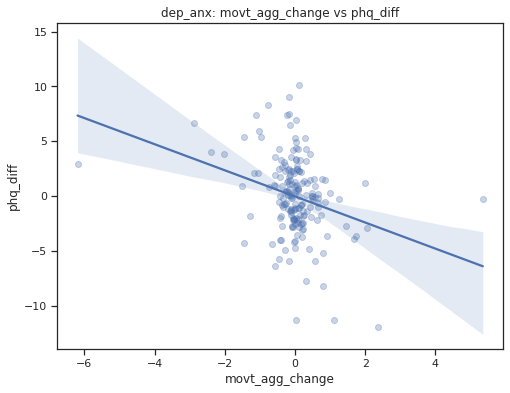

In [54]:
ls_utils.plot_cluster_scatter('movt_agg_change', 'phq_diff', phq_corr, 'dep_anx', (8,6))

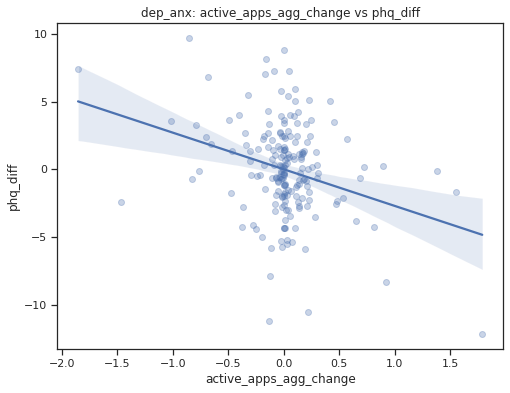

In [55]:
ls_utils.plot_cluster_scatter('active_apps_agg_change', 'phq_diff', phq_corr, 'dep_anx', (8,6))

# Reverse PHQ

## Full population

In [56]:
ls_utils.display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.001,0.9632,0.9632,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,-0.059,0.0524*,0.1975,fdr_bh
2,social_apps_agg_change,phq_diff,1079,-0.018,0.5611,0.7772,fdr_bh
3,work_dur_agg_change,phq_diff,1078,-0.016,0.5986,0.7772,fdr_bh
4,home_dur_agg_change,phq_diff,1078,0.021,0.4958,0.7772,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.078,0.0101*,0.1519,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,-0.069,0.0228*,0.1707,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,-0.011,0.7254,0.7772,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.033,0.2757,0.7772,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.027,0.3696,0.7772,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.003,0.9311,0.9633,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,-0.043,0.1559,0.9633,fdr_bh
2,social_apps_agg_change,phq_diff,1079,-0.015,0.6267,0.9633,fdr_bh
3,work_dur_agg_change,phq_diff,1078,-0.024,0.4272,0.9633,fdr_bh
4,home_dur_agg_change,phq_diff,1078,-0.006,0.8505,0.9633,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.062,0.0429*,0.6431,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,-0.008,0.7879,0.9633,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,0.015,0.6164,0.9633,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.008,0.7988,0.9633,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.031,0.3052,0.9633,fdr_bh


## no_symp

In [57]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,326,-0.085,0.1250,0.4689,fdr_bh
1,passive_apps_agg_change,phq_diff,326,0.027,0.6327,0.7404,fdr_bh
2,social_apps_agg_change,phq_diff,326,0.028,0.6110,0.7404,fdr_bh
3,work_dur_agg_change,phq_diff,325,-0.017,0.7625,0.7625,fdr_bh
4,home_dur_agg_change,phq_diff,325,0.09,0.1037,0.4689,fdr_bh
5,religion_dur_agg_change,phq_diff,325,-0.057,0.3053,0.6697,fdr_bh
6,exercise_dur_agg_change,phq_diff,325,-0.066,0.2348,0.6697,fdr_bh
7,shopping_dur_agg_change,phq_diff,325,-0.028,0.6193,0.7404,fdr_bh
8,other_dur_agg_change,phq_diff,325,-0.026,0.6416,0.7404,fdr_bh
9,social_dur_agg_change,phq_diff,325,-0.02,0.7227,0.7625,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,326,-0.074,0.1854,0.5647,fdr_bh
1,passive_apps_agg_change,phq_diff,326,0.154,0.0054*,0.0809*,fdr_bh
2,social_apps_agg_change,phq_diff,326,0.075,0.1749,0.5647,fdr_bh
3,work_dur_agg_change,phq_diff,325,0.005,0.9319,0.9319,fdr_bh
4,home_dur_agg_change,phq_diff,325,0.056,0.3102,0.5647,fdr_bh
5,religion_dur_agg_change,phq_diff,325,0.017,0.7650,0.8196,fdr_bh
6,exercise_dur_agg_change,phq_diff,325,-0.073,0.1866,0.5647,fdr_bh
7,shopping_dur_agg_change,phq_diff,325,0.045,0.4141,0.5647,fdr_bh
8,other_dur_agg_change,phq_diff,325,0.047,0.3953,0.5647,fdr_bh
9,social_dur_agg_change,phq_diff,325,-0.047,0.4016,0.5647,fdr_bh


## soc_anx

In [58]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,293,0.017,0.7731,0.8921,fdr_bh
1,passive_apps_agg_change,phq_diff,293,-0.076,0.1971,0.7393,fdr_bh
2,social_apps_agg_change,phq_diff,293,0.042,0.4770,0.8520,fdr_bh
3,work_dur_agg_change,phq_diff,293,-0.053,0.3658,0.8520,fdr_bh
4,home_dur_agg_change,phq_diff,293,-0.003,0.9560,0.9560,fdr_bh
5,religion_dur_agg_change,phq_diff,293,-0.105,0.0726*,0.5079,fdr_bh
6,exercise_dur_agg_change,phq_diff,293,-0.126,0.0307*,0.4607,fdr_bh
7,shopping_dur_agg_change,phq_diff,293,0.063,0.2793,0.8378,fdr_bh
8,other_dur_agg_change,phq_diff,293,0.045,0.4450,0.8520,fdr_bh
9,social_dur_agg_change,phq_diff,293,0.022,0.7015,0.8921,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,293,-0.019,0.7396,0.8953,fdr_bh
1,passive_apps_agg_change,phq_diff,293,-0.085,0.1489,0.6246,fdr_bh
2,social_apps_agg_change,phq_diff,293,0.008,0.8953,0.8953,fdr_bh
3,work_dur_agg_change,phq_diff,293,-0.024,0.6804,0.8953,fdr_bh
4,home_dur_agg_change,phq_diff,293,-0.042,0.4691,0.8953,fdr_bh
5,religion_dur_agg_change,phq_diff,293,-0.038,0.5204,0.8953,fdr_bh
6,exercise_dur_agg_change,phq_diff,293,0.018,0.7635,0.8953,fdr_bh
7,shopping_dur_agg_change,phq_diff,293,0.117,0.0451*,0.6246,fdr_bh
8,other_dur_agg_change,phq_diff,293,0.025,0.6721,0.8953,fdr_bh
9,social_dur_agg_change,phq_diff,293,0.031,0.5966,0.8953,fdr_bh


## gen_anx

In [59]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,268,0.002,0.9693,0.9757,fdr_bh
1,passive_apps_agg_change,phq_diff,268,-0.113,0.0640*,0.3198,fdr_bh
2,social_apps_agg_change,phq_diff,268,-0.025,0.6895,0.9402,fdr_bh
3,work_dur_agg_change,phq_diff,268,-0.031,0.6166,0.9402,fdr_bh
4,home_dur_agg_change,phq_diff,268,0.009,0.8811,0.9757,fdr_bh
5,religion_dur_agg_change,phq_diff,268,-0.114,0.0632*,0.3198,fdr_bh
6,exercise_dur_agg_change,phq_diff,268,-0.026,0.6662,0.9402,fdr_bh
7,shopping_dur_agg_change,phq_diff,268,-0.045,0.4623,0.9402,fdr_bh
8,other_dur_agg_change,phq_diff,268,-0.146,0.0170*,0.2553,fdr_bh
9,social_dur_agg_change,phq_diff,268,-0.026,0.6661,0.9402,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,268,0.032,0.6019,0.8208,fdr_bh
1,passive_apps_agg_change,phq_diff,268,-0.082,0.1825,0.8208,fdr_bh
2,social_apps_agg_change,phq_diff,268,-0.036,0.5534,0.8208,fdr_bh
3,work_dur_agg_change,phq_diff,268,-0.066,0.2806,0.8208,fdr_bh
4,home_dur_agg_change,phq_diff,268,-0.003,0.9643,0.9643,fdr_bh
5,religion_dur_agg_change,phq_diff,268,-0.166,0.0064*,0.0953*,fdr_bh
6,exercise_dur_agg_change,phq_diff,268,0.007,0.9135,0.9643,fdr_bh
7,shopping_dur_agg_change,phq_diff,268,-0.069,0.2616,0.8208,fdr_bh
8,other_dur_agg_change,phq_diff,268,-0.074,0.2287,0.8208,fdr_bh
9,social_dur_agg_change,phq_diff,268,-0.034,0.5849,0.8208,fdr_bh


## dep_anx

In [60]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,192,0.102,0.1599,0.6100,fdr_bh
1,passive_apps_agg_change,phq_diff,192,-0.102,0.1602,0.6100,fdr_bh
2,social_apps_agg_change,phq_diff,192,-0.099,0.1706,0.6100,fdr_bh
3,work_dur_agg_change,phq_diff,192,0.082,0.2556,0.6100,fdr_bh
4,home_dur_agg_change,phq_diff,192,-0.015,0.8359,0.9292,fdr_bh
5,religion_dur_agg_change,phq_diff,192,0.012,0.8693,0.9292,fdr_bh
6,exercise_dur_agg_change,phq_diff,192,-0.035,0.6333,0.8636,fdr_bh
7,shopping_dur_agg_change,phq_diff,192,-0.071,0.3253,0.6100,fdr_bh
8,other_dur_agg_change,phq_diff,192,0.016,0.8301,0.9292,fdr_bh
9,social_dur_agg_change,phq_diff,192,-0.091,0.2101,0.6100,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,192,0.091,0.2089,0.4667,fdr_bh
1,passive_apps_agg_change,phq_diff,192,-0.148,0.0402*,0.3014,fdr_bh
2,social_apps_agg_change,phq_diff,192,-0.115,0.1127,0.4667,fdr_bh
3,work_dur_agg_change,phq_diff,192,-0.013,0.8608,0.8608,fdr_bh
4,home_dur_agg_change,phq_diff,192,-0.035,0.6284,0.8608,fdr_bh
5,religion_dur_agg_change,phq_diff,192,-0.023,0.7503,0.8608,fdr_bh
6,exercise_dur_agg_change,phq_diff,192,0.091,0.2078,0.4667,fdr_bh
7,shopping_dur_agg_change,phq_diff,192,-0.026,0.7212,0.8608,fdr_bh
8,other_dur_agg_change,phq_diff,192,-0.02,0.7779,0.8608,fdr_bh
9,social_dur_agg_change,phq_diff,192,-0.07,0.3321,0.5906,fdr_bh


# Summary Tables of Significant Correlations

## SPIN

In [61]:
ls_utils.build_corr_table(gad_spin_corr, 'passive_apps_agg_change', agg_cols_change, 'spin_diff', 'passive app change to SPIN change')

,group,n,r,p-corr,p-adjust
0,all,1028,0.043,0.499518,fdr_bh
1,no_symp,325,0.04,0.813552,fdr_bh
2,soc_anx,267,0.039,0.774855,fdr_bh
3,gen_anx,252,0.006,0.923263,fdr_bh
4,dep_anx,184,0.138,0.812702,fdr_bh


In [62]:
ls_utils.build_corr_table(rev_gad_spin_corr, 'passive_apps_agg_change', agg_cols_change, 'spin_diff', 'SPIN change to passive app change')

,group,n,r,p-corr,p-adjust
0,all,1023,-0.008,0.914857,fdr_bh
1,no_symp,325,0.028,0.769864,fdr_bh
2,soc_anx,266,-0.126,0.298188,fdr_bh
3,gen_anx,251,0.037,0.654608,fdr_bh
4,dep_anx,181,0.089,0.990724,fdr_bh


## GAD

In [63]:
ls_utils.build_corr_table(gad_spin_corr, 'active_apps_agg_change', agg_cols_change, 'gad_diff', 'location PCA change to GAD change', method='spearman')

,group,n,r,p-corr,p-adjust
0,all,1029,0.083,0.0720428,fdr_bh
1,no_symp,325,0.003,0.956715,fdr_bh
2,soc_anx,267,0.189,0.0274913,fdr_bh
3,gen_anx,253,0.138,0.426364,fdr_bh
4,dep_anx,184,-0.014,0.852701,fdr_bh


In [64]:
ls_utils.build_corr_table(rev_gad_spin_corr, 'active_apps_agg_change', agg_cols_change, 'gad_diff', 'GAD change to location PCA change', method='spearman')

,group,n,r,p-corr,p-adjust
0,all,1023,0.022,0.658169,fdr_bh
1,no_symp,325,0.07,0.490289,fdr_bh
2,soc_anx,266,-0.054,0.537091,fdr_bh
3,gen_anx,251,0.032,0.659549,fdr_bh
4,dep_anx,181,0.044,0.927326,fdr_bh


## PHQ

In [85]:
ls_utils.build_corr_table(phq_corr, 'movt_agg_change', agg_cols_change, 'phq_diff', 'location PCA change to PHQ change')

,group,n,r,p-corr,p-adjust
0,all,1073,-0.169,3.65375e-07,fdr_bh
1,no_symp,325,-0.083,0.343012,fdr_bh
2,soc_anx,292,-0.163,0.0385915,fdr_bh
3,gen_anx,268,-0.196,0.0190749,fdr_bh
4,dep_anx,188,-0.305,0.00015621,fdr_bh


In [86]:
ls_utils.build_corr_table(rev_phq_corr, 'movt_agg_change', agg_cols_change, 'phq_diff', 'PHQ change to location PCA change')

,group,n,r,p-corr,p-adjust
0,all,1072,0.016,0.777222,fdr_bh
1,no_symp,325,0.031,0.740355,fdr_bh
2,soc_anx,291,-0.009,0.935446,fdr_bh
3,gen_anx,266,-0.007,0.975713,fdr_bh
4,dep_anx,190,0.049,0.810089,fdr_bh


# Change over Time Periods Analysis

## Functions

In [67]:
def plot_over_time(cols, df, title, study_wks=[4,7,10,13,16], figsize=(8,6)):
    _, ax = plt.subplots(figsize=figsize)
    for col in cols:
        cal_pairs = df[df['X'] == col]
        errs = np.concatenate(cal_pairs['CI95%'].values).reshape(len(cal_pairs['r'].values),2).T
        #print(len(cal_pairs['r'].values))
        errs = errs - cal_pairs['r'].values
        errs = np.abs(errs)
        #errs = np.flip(errs,0)
        plt.errorbar(x=cal_pairs['idx'], y=cal_pairs['r'], yerr=errs, label=col, capsize=5)
    

    plt.axhline(y=0, ls='--')
    plt.xlabel("study_wk")
    plt.xticks(study_wks)
    plt.title(title)
    plt.legend()
    
    return plt    

In [68]:
def build_time_corr_df(seq_df, target, feat_cols, study_wks=[4,7,10,13,16]):
    pair_df = pd.DataFrame()
    for idx in study_wks:
        sel_df = seq_df[seq_df['study_wk'] == idx]
        #sel_df = sel_df.dropna(subset=['date'])
        sel_df = sel_df[[target] + feat_cols]
        df = pg.pairwise_corr(sel_df, columns=[feat_cols, [target]], padjust="fdr_bh")
        df['idx'] = idx
        pair_df = pair_df.append(df)
        
    return pair_df

## PHQ

In [69]:
pop_df = build_time_corr_df(phq_corr, 'phq_diff', agg_cols_change)

In [70]:
pop_df[pop_df['X'] == 'movt_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
12,movt_agg_change,phq_diff,197,-0.021,4,0.772803,0.902267,fdr_bh,"[-0.16, 0.12]"
12,movt_agg_change,phq_diff,197,-0.301,7,0.000017,0.000262,fdr_bh,"[-0.42, -0.17]"
12,movt_agg_change,phq_diff,229,-0.163,10,0.013285,0.067400,fdr_bh,"[-0.29, -0.03]"
12,movt_agg_change,phq_diff,228,-0.129,13,0.052362,0.552092,fdr_bh,"[-0.25, 0.0]"
12,movt_agg_change,phq_diff,222,-0.182,16,0.006427,0.096404,fdr_bh,"[-0.31, -0.05]"


(-1, 0.6)

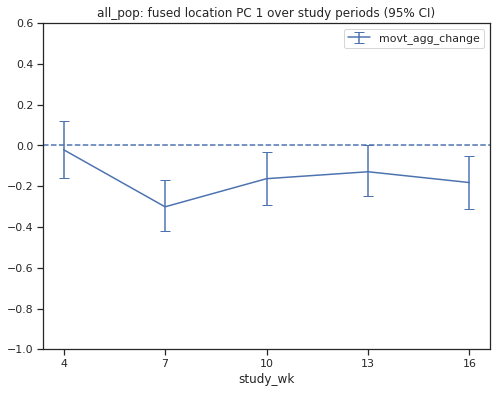

In [71]:
p = plot_over_time(['movt_agg_change'], pop_df, "all_pop: fused location PC 1 over study periods (95% CI)")
p.ylim(-1,0.6)

In [72]:
dep_anx_df = build_time_corr_df(phq_corr[phq_corr['baseline_cluster'] == 'dep_anx'], 'phq_diff', agg_cols_change)

In [73]:
dep_anx_df[dep_anx_df['X'] == 'movt_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
12,movt_agg_change,phq_diff,34,-0.393,4,0.021398,0.320969,fdr_bh,"[-0.65, -0.06]"
12,movt_agg_change,phq_diff,33,-0.593,7,0.000275,0.004132,fdr_bh,"[-0.78, -0.31]"
12,movt_agg_change,phq_diff,40,-0.365,10,0.020468,0.071437,fdr_bh,"[-0.61, -0.06]"
12,movt_agg_change,phq_diff,41,-0.033,13,0.840115,0.840115,fdr_bh,"[-0.34, 0.28]"
12,movt_agg_change,phq_diff,40,-0.352,16,0.025956,0.194672,fdr_bh,"[-0.6, -0.05]"


(-1, 0.6)

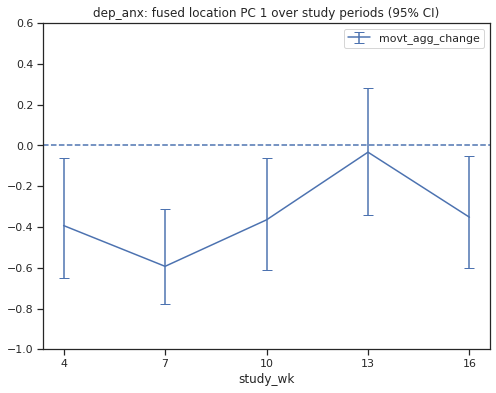

In [74]:
p = plot_over_time(['movt_agg_change'], dep_anx_df, "dep_anx: fused location PC 1 over study periods (95% CI)")
p.ylim(-1,0.6)

## GAD

In [75]:
gad_df = build_time_corr_df(gad_spin_corr, 'gad_diff', agg_cols_change, study_wks=[7,10,13,16])

In [76]:
gad_df[gad_df['X'] == 'social_apps_agg_change']

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power,idx
2,social_apps_agg_change,gad_diff,pearson,two-sided,256,-0.131,"[-0.25, -0.01]",0.017,0.009,-0.132,0.036219,0.249266,fdr_bh,0.693,0.555,7
2,social_apps_agg_change,gad_diff,pearson,two-sided,257,0.048,"[-0.07, 0.17]",0.002,-0.006,0.048,0.444904,0.750195,fdr_bh,0.104,0.119,10
2,social_apps_agg_change,gad_diff,pearson,two-sided,258,-0.043,"[-0.16, 0.08]",0.002,-0.006,-0.043,0.489708,0.911332,fdr_bh,0.099,0.106,13
2,social_apps_agg_change,gad_diff,pearson,two-sided,258,0.049,"[-0.07, 0.17]",0.002,-0.005,0.049,0.428970,0.804319,fdr_bh,0.106,0.124,16


In [77]:
dep_anx_gad_df = build_time_corr_df(gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx'], 'gad_diff', agg_cols_change, study_wks=[7,10,13,16])

In [78]:
dep_anx_gad_df[dep_anx_gad_df['X'] == 'social_apps_agg_change']

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power,idx
2,social_apps_agg_change,gad_diff,pearson,two-sided,46,-0.336,"[-0.57, -0.05]",0.113,0.072,-0.350,0.022222,0.166668,fdr_bh,2.317,0.640,7
2,social_apps_agg_change,gad_diff,pearson,two-sided,46,0.027,"[-0.27, 0.32]",0.001,-0.046,0.027,0.856585,0.964025,fdr_bh,0.187,0.053,10
2,social_apps_agg_change,gad_diff,pearson,two-sided,46,-0.317,"[-0.56, -0.03]",0.100,0.058,-0.328,0.031993,0.479893,fdr_bh,1.708,0.584,13
2,social_apps_agg_change,gad_diff,pearson,two-sided,46,-0.148,"[-0.42, 0.15]",0.022,-0.023,-0.149,0.325155,0.806677,fdr_bh,0.294,0.167,16


## SPIN

In [79]:
spin_df = build_time_corr_df(gad_spin_corr, 'spin_diff', agg_cols_change, study_wks=[7,10,13,16])

In [80]:
spin_df[spin_df['X'] == 'passive_apps_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
1,passive_apps_agg_change,spin_diff,256,-0.038,7,0.547392,0.821088,fdr_bh,"[-0.16, 0.09]"
1,passive_apps_agg_change,spin_diff,257,0.082,10,0.189748,0.687406,fdr_bh,"[-0.04, 0.2]"
1,passive_apps_agg_change,spin_diff,258,0.068,13,0.279714,0.811239,fdr_bh,"[-0.06, 0.19]"
1,passive_apps_agg_change,spin_diff,257,0.121,16,0.052943,0.264717,fdr_bh,"[-0.0, 0.24]"


(-0.4, 1)

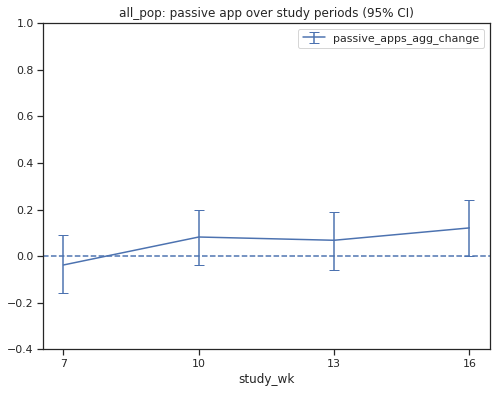

In [81]:
p = plot_over_time(['passive_apps_agg_change'], spin_df, "all_pop: passive app over study periods (95% CI)", study_wks=[7,10,13,16])
p.ylim(-0.4,1)

In [82]:
soc_anx_spin_df = build_time_corr_df(gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx'], 'spin_diff', agg_cols_change, study_wks=[7,10,13,16])

In [83]:
soc_anx_spin_df[soc_anx_spin_df['X'] == 'passive_apps_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
1,passive_apps_agg_change,spin_diff,66,-0.283,7,0.021374,0.160309,fdr_bh,"[-0.49, -0.04]"
1,passive_apps_agg_change,spin_diff,66,0.233,10,0.059851,0.472678,fdr_bh,"[-0.01, 0.45]"
1,passive_apps_agg_change,spin_diff,67,0.291,13,0.016723,0.125423,fdr_bh,"[0.06, 0.5]"
1,passive_apps_agg_change,spin_diff,68,0.299,16,0.013118,0.196777,fdr_bh,"[0.07, 0.5]"


(-0.4, 1)

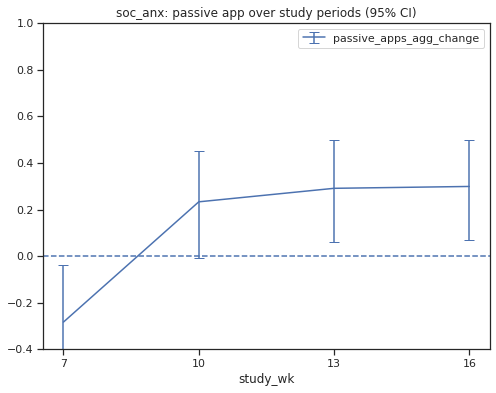

In [84]:
p = plot_over_time(['passive_apps_agg_change'], soc_anx_spin_df, "soc_anx: passive app over study periods (95% CI)", study_wks=[7,10,13,16])
p.ylim(-0.4,1)